# HETEROGENEITY UPLIFT

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
    
from uplift import t_learner, x_learner, uplift_summary

In [3]:
# Simulate user-level data
np.random.seed(42)
n_users = 1000
df = pd.DataFrame({
    'user_id': np.arange(n_users),
    'variant': np.random.choice(['control','treatment'], n_users),
    'past_7d_gpv': np.random.normal(100, 20, n_users),
    'country': np.random.choice(['US','IN','UK'], n_users),
    'device': np.random.choice(['desktop','mobile'], n_users),
    'traffic_source': np.random.choice(['organic','paid'], n_users)
})

In [4]:
# Simulate GPV outcome with heterogeneous treatment effect
df['true_effect'] = np.where((df['device']=='mobile') & (df['country']=='IN'), 0.05, 0.02)
df['gpv'] = df['past_7d_gpv'] * (1 + df['true_effect'] * (df['variant']=='treatment'))
df['gpv'] += np.random.normal(0,5,n_users)  # add noise

In [5]:
# Uplift modeling
df['treat'] = df['variant'].map({'control': 0, 'treatment': 1})

numerical_features = ['past_7d_gpv']
categorical_features = ['country', 'device', 'traffic_source']

In [6]:
# One-hot encode categorical features
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
encoded_cols = [col for col in df_encoded.columns if any(cat in col for cat in categorical_features)]
all_features = numerical_features + encoded_cols

df_filtered = df_encoded[df_encoded['variant'].isin(['control', 'treatment'])].copy()

outcome_col = 'gpv'
treat_col = 'treat'

In [7]:
# Fit learners
t_learner_res = t_learner(df_filtered, outcome_col, treat_col, all_features)
x_learner_res = x_learner(df_filtered, outcome_col, treat_col, all_features)

df = df.merge(t_learner_res, on='user_id', how='left').rename(columns={'cate':'cate_t'})
df = df.merge(x_learner_res, on='user_id', how='left').rename(columns={'cate':'cate_x'})

In [8]:
# Summary
print("T-Learner CATE summary:")
print(uplift_summary(t_learner_res))
print("\nX-Learner CATE summary:")
print(uplift_summary(x_learner_res))

segment_summary = df.groupby(['device','country']).agg({
    'cate_t':['mean','std','count'],
    'cate_x':['mean','std','count']
}).reset_index()

T-Learner CATE summary:
{'total_users': 300, 'positive_lift_pct': 0.78, 'top_10pct_users_summary':          user_id       cate
count   30.00000  30.000000
mean   466.20000   7.547904
std    304.77062   1.662937
min      3.00000   6.337852
25%    215.00000   6.545305
50%    496.50000   6.858739
75%    678.25000   7.859364
max    985.00000  13.421611}

X-Learner CATE summary:
{'total_users': 300, 'positive_lift_pct': 0.5433333333333333, 'top_10pct_users_summary':           user_id       cate
count   30.000000  30.000000
mean   477.800000  48.744744
std    298.258324  10.716086
min      7.000000  36.503588
25%    231.250000  39.850145
50%    469.000000  47.941206
75%    709.000000  54.124181
max    986.000000  80.099858}


In [9]:
# Flatten columns
segment_summary.columns = ['device','country',
                           'cate_t_mean','cate_t_std','cate_t_count',
                           'cate_x_mean','cate_x_std','cate_x_count']

print("\nSegment-level CATE summary:")
print(segment_summary)


Segment-level CATE summary:
    device country  cate_t_mean  cate_t_std  cate_t_count  cate_x_mean  \
0  desktop      IN     0.673826    2.190341            48     0.596014   
1  desktop      UK     2.108959    2.886217            52     5.265220   
2  desktop      US     1.705664    2.991212            57    -2.713749   
3   mobile      IN     2.875281    2.628760            46     8.938234   
4   mobile      UK     4.046270    3.158518            47    10.972747   
5   mobile      US     2.797554    2.809690            50   -11.658037   

   cate_x_std  cate_x_count  
0   25.506042            48  
1   33.525954            52  
2   24.501343            57  
3   26.145653            46  
4   24.526499            47  
5   27.404633            50  


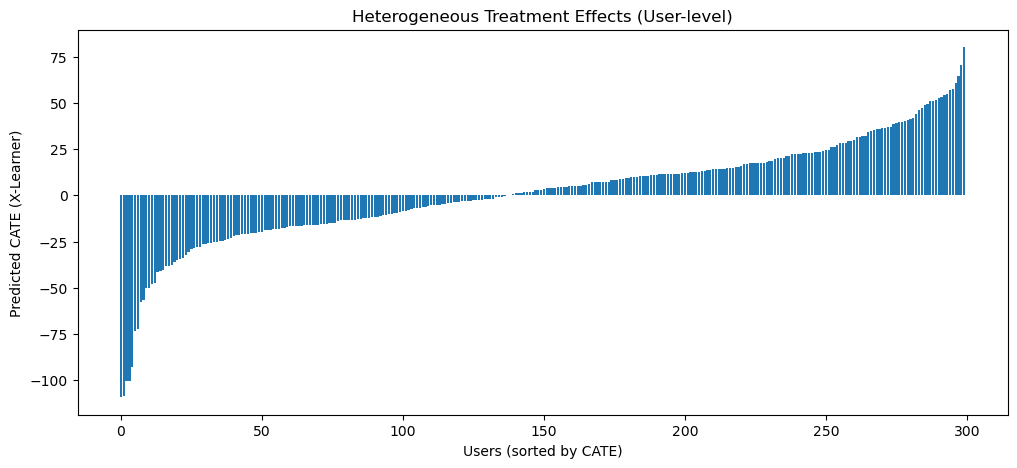

In [10]:
# Visualization: heterogeneity waterfall
plt.figure(figsize=(12,5))
plt.bar(np.arange(len(df)), np.sort(df['cate_x'].values))
plt.xlabel("Users (sorted by CATE)")
plt.ylabel("Predicted CATE (X-Learner)")
plt.title("Heterogeneous Treatment Effects (User-level)")
plt.show()

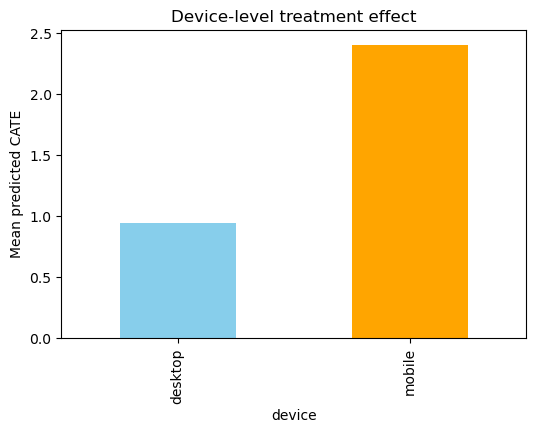

In [11]:
# Partial dependence for device
mean_cate_by_device = df.groupby('device')['cate_x'].mean()
plt.figure(figsize=(6,4))
mean_cate_by_device.plot(kind='bar', color=['skyblue','orange'])
plt.ylabel("Mean predicted CATE")
plt.title("Device-level treatment effect")
plt.show()

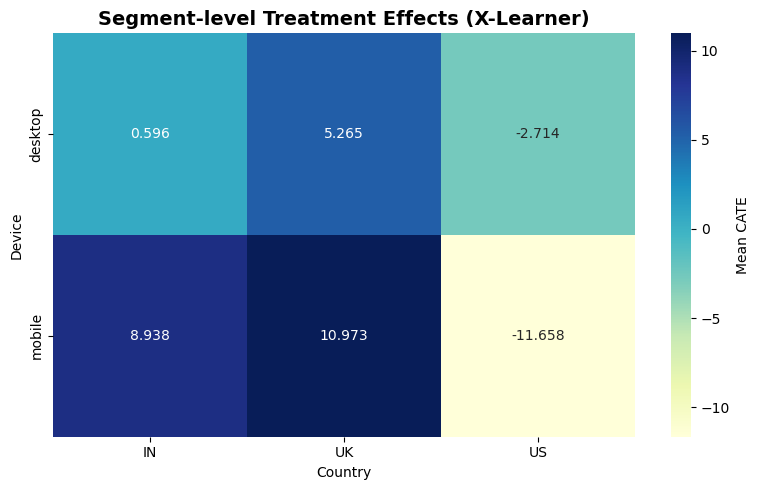

In [12]:
# Segment-level heatmap (X-Learner)
plt.figure(figsize=(8, 5))
pivot_seg = segment_summary.pivot(index="device", columns="country", values="cate_x_mean")
sns.heatmap(pivot_seg, annot=True, fmt=".3f", cmap="YlGnBu",
            cbar_kws={'label': 'Mean CATE'})
plt.title("Segment-level Treatment Effects (X-Learner)", fontsize=14, fontweight="bold")
plt.ylabel("Device")
plt.xlabel("Country")
plt.tight_layout()
plt.show()